# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from timeMethods import *
from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
fileName = '../build/1800MeV_mu_-1.21x3_1x3.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 2575


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 178


# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Time Bins

In [8]:
time_min = -1
time_max = -1
time_nBins = 10

df_hits = make_timeBins(df_hits, nBins=time_nBins, min=time_min, max=time_max)

# Basic Hit Reco

In [9]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)
df_hits = make_relativeVector(df_hits)  

  0%|          | 0/2575 [00:00<?, ?it/s]

100%|██████████| 2575/2575 [00:00<00:00, 71144.22it/s]


# Make or Load Grid

In [10]:
gridSize = (50, 50, 50)
makeErrors = False
save = False
savePlots = False
load = False
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 50x50x50_1800MeV_mu_-1_noErrors


In [11]:
grids, grids_ind, grids_pos = [], [], []

for timeStep in tqdm.tqdm(range(time_nBins)):
    if not load:
        df_hits_time = df_hits[df_hits['time_bin']==timeStep]
        grid, grid_ind, grid_pos = get_voxelGrid(
            gridSize,
            DETECTOR_SIZE_MM,
            np.array(df_hits_time['sensor_position'].to_list()).reshape(-1,3),
            np.array(df_hits_time['reconstructedVector_direction'].to_list()).reshape(-1,3),
            [1 for i in range(len(df_hits_time))],
            20,
            makeErrors
        )
        grids    .append(grid    )
        grids_ind.append(grid_ind)
        grids_pos.append(grid_pos)
        
        if save:
            np.savez('data/{}_{}.npz'.format(plotRecoName, timeStep), grid=grid, grid_ind=grid_ind, grid_pos=grid_pos)

    else:
        data = np.load('data/{}_{}.npz'.format(plotRecoName, timeStep))
        grid     = data['grid'    ]
        grid_ind = data['grid_ind']
        grid_pos = data['grid_pos']
        grids    .append(grid    )
        grids_ind.append(grid_ind)
        grids_pos.append(grid_pos)

100%|██████████| 10/10 [00:00<00:00, 19.11it/s]


In [12]:
primary_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
primary_true = primary_true[np.where((primary_true[:, 0] <  DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] <  DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] <  DETECTOR_SIZE_MM[2]/2) & 
                                     (primary_true[:, 0] > -DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] > -DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] > -DETECTOR_SIZE_MM[2]/2))]

# Plotting Methods

In [13]:
def plotSlice(grid, pos, i, axis, size_1, size_2, ax=None, show=True, save=False, saveName='test.png'):
    if ax is None:
        fig, ax = plt.subplots()

    if axis == 0:
        slice = grid[i,:,:]
    elif axis == 1:
        slice = grid[:,i,:]
    elif axis == 2:
        slice = grid[:,:,i]

    imshow = ax.imshow(slice, cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
    ax.scatter(pos[i,0], pos[i,1], c='r', marker='o', s=20)
    cbar = ax.figure.colorbar(imshow, ax=ax, label='Color Bar (Log Scale)')

    if show:
        plt.show()
    if save:
        plt.savefig(saveName)

    plt.close(fig)

def makeAnimation(grid, pos, axis, size_1, size_2, save=False, saveName='test.gif'):
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        if axis == 0:
            slice = grid[i,:,:]
        elif axis == 1:
            slice = grid[:,i,:]
        elif axis == 2:
            slice = grid[:,:,i]
            
        imshow = ax.imshow(slice, cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
        ax.scatter(pos[i,0], pos[i,1], c='r', marker='o', s=20)
        # cbar = ax.figure.colorbar(imshow, ax=ax, label='Color Bar (Log Scale)')
        return imshow
        
    anim = FuncAnimation(fig, update, frames=grid.shape[0], interval=100)
    anim.save(saveName, dpi=80, writer='imagemagick')
    return anim


In [14]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Mean Slice Reconstruction

In [15]:
showPlots = False
savePlots = False
saveAnima = False
saveDir = '../figures/voxelGrid_mean_{}'.format(plotRecoName)

pos_avg = np.zeros((grid.shape[0], 2))
for x in np.arange(grid.shape[0]):
    val_y = np.mean(grid[x,:,:], axis=0)
    val_z = np.mean(grid[x,:,:], axis=1)
    if np.sum(val_y) == 0 or np.sum(val_z) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,0] == x)][:,1:3]
    pos_avg[x,0] = np.average(np.unique(pos[:,0]), weights=val_y)
    pos_avg[x,1] = np.average(np.unique(pos[:,1]), weights=val_z)
    plotSlice(grid, pos_avg, x, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/x_{}.pdf'.format(saveDir, x))
if saveAnima:
    makeAnimation(grid, pos_avg, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/x.gif'.format(saveDir))
X_mean = np.array([np.unique(grid_pos[:,0]), pos_avg[:,0], pos_avg[:,1]]).T

pos_avg = np.zeros((grid.shape[1], 2))
for y in np.arange(grid.shape[1]):
    val_x = np.mean(grid[:,y,:], axis=0)
    val_z = np.mean(grid[:,y,:], axis=1)
    if np.sum(val_x) == 0 or np.sum(val_z) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,1] == y)][:,[0,2]]
    pos_avg[y,0] = np.average(np.unique(pos[:,0]), weights=val_x)
    pos_avg[y,1] = np.average(np.unique(pos[:,1]), weights=val_z)
    plotSlice(grid, pos_avg, y, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/y_{}.pdf'.format(saveDir, y))
if saveAnima:
    makeAnimation(grid, pos_avg, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/y.gif'.format(saveDir))
Y_mean = np.array([pos_avg[:,0], np.unique(grid_pos[:,1]), pos_avg[:,1]]).T

pos_avg = np.zeros((grid.shape[2],2))
for z in np.arange(grid.shape[2]):
    val_x = np.mean(grid[:,:,z], axis=0)
    val_y = np.mean(grid[:,:,z], axis=1)
    if np.sum(val_x) == 0 or np.sum(val_y) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,2] == z)][:,:2]
    pos_avg[z,0] = np.average(np.unique(pos[:,0]), weights=val_x)
    pos_avg[z,1] = np.average(np.unique(pos[:,1]), weights=val_y)
    plotSlice(grid, pos_avg, z, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, show=showPlots, save=savePlots, saveName='{}/z_{}.pdf'.format(saveDir, z))
if saveAnima:
    makeAnimation(grid, pos_avg, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, save=savePlots, saveName='{}/z.gif'.format(saveDir))
Z_mean = np.array([pos_avg[:,0], pos_avg[:,1], np.unique(grid_pos[:,2])]).T

avg_mean = np.mean(np.array([X_mean,Y_mean,Z_mean]), axis=0)

In [17]:
A_xz = np.vstack([avg_mean[:,0], np.ones(len(avg_mean[:,0]))]).T
m_xz, c_xz = np.linalg.lstsq(A_xz, avg_mean[:,1])[0]

A_yz = np.vstack([avg_mean[:,1], np.ones(len(avg_mean[:,1]))]).T
m_yz, c_yz = np.linalg.lstsq(A_yz, avg_mean[:,2])[0]

def lin(z):
    x = (z - c_xz)/m_xz
    y = (z - c_yz)/m_yz
    return x, y

zz = primary_true[:,2]
xx, yy = lin(zz)

avg_mean_lin = np.array([xx, yy, zz]).T

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/4160363666.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_xz, c_xz = np.linalg.lstsq(A_xz, avg_mean[:,1])[0]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/4160363666.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_yz, c_yz = np.linalg.lstsq(A_yz, avg_mean[:,2])[0]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/2757197959.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


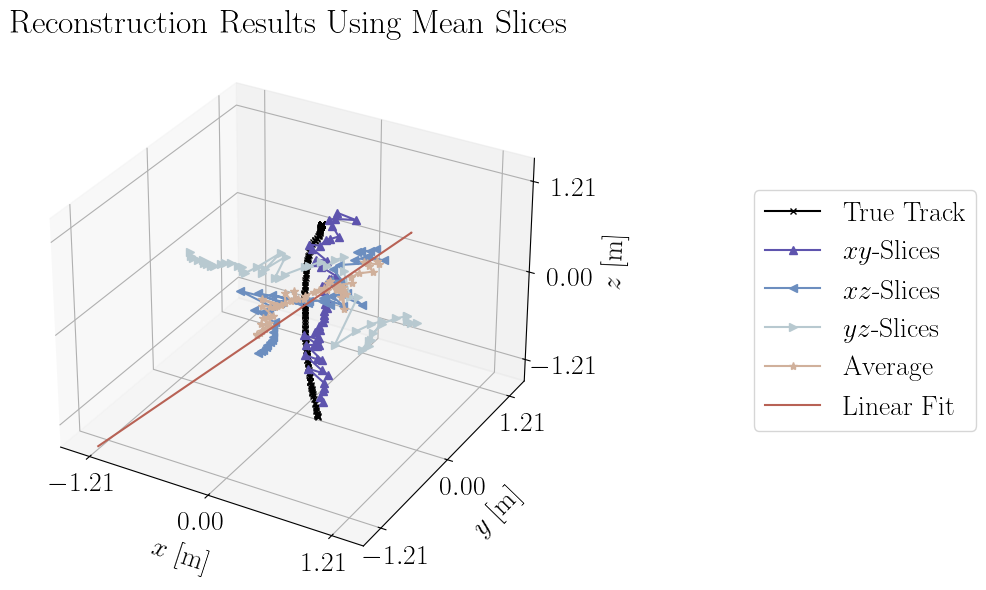

In [18]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# voxelGrid       = ax.scatter(grid_pos    [:,0]/1000, grid_pos    [:,1]/1000, grid_pos    [:,2]/1000, c=grid[grid >= 0], cmap='viridis', marker='D', alpha=0.02, s=10, norm=LogNorm())  # Use LogNorm for log scale
track_true      = ax.plot(primary_true[:,0]/1000, primary_true[:,1]/1000, primary_true[:,2]/1000, c='black'       , marker='x', markersize=5, label='True Track' , linewidth=1.5)
track_reco_Z    = ax.plot(Z_mean      [:,0]/1000, Z_mean      [:,1]/1000, Z_mean      [:,2]/1000, c=twilight[12,:], marker='^', markersize=6, label='$xy$-Slices', linewidth=1.5)
track_reco_Y    = ax.plot(Y_mean      [:,0]/1000, Y_mean      [:,1]/1000, Y_mean      [:,2]/1000, c=twilight[8 ,:], marker='<', markersize=6, label='$xz$-Slices', linewidth=1.5)
track_reco_X    = ax.plot(X_mean      [:,0]/1000, X_mean      [:,1]/1000, X_mean      [:,2]/1000, c=twilight[3 ,:], marker='>', markersize=6, label='$yz$-Slices', linewidth=1.5)
track_reco      = ax.plot(avg_mean    [:,0]/1000, avg_mean    [:,1]/1000, avg_mean    [:,2]/1000, c=twilight[35,:], marker='*', markersize=6, label='Average'    , linewidth=1.5)
track_reco_line = ax.plot(avg_mean_lin[:,0]/1000, avg_mean_lin[:,1]/1000, avg_mean_lin[:,2]/1000, c=twilight[30,:], marker='o', markersize=0, label='Linear Fit' , linewidth=1.5)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.set_title('Reconstruction Results Using Mean Slices')
ax.set_title('Reconstruction Results Using Mean Slices', loc='center')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')

ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

if savePlots:
    fig.savefig('../figures/trackReconstruction_mean_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/744900799.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

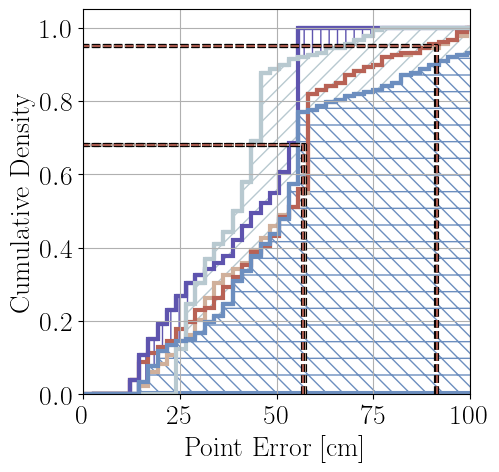

In [19]:
distances_X = cdist(primary_true, X_mean)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_mean)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_mean)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_mean)
distances_pts = np.min(distances_pts, axis=1)

distances_pts_lin = cdist(primary_true, avg_mean_lin)
distances_pts_lin = np.min(distances_pts_lin, axis=1)

scale = 10
lw = 3
nBins = 50
alpha1 = 0.5
alpha2 = 1

PDF, _, _, bins = get_PDF(distances_pts/scale, nBins=nBins)
sigma_1_avg = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_avg = get_CSP('2 sigma', PDF=PDF, bins=bins)
PDF, _, _, bins = get_PDF(distances_pts_lin/scale, nBins=nBins)
sigma_1_avg_lin = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_avg_lin = get_CSP('2 sigma', PDF=PDF, bins=bins)

fig, ax_2 = plt.subplots(1, 1, figsize=(5,5))
bins = np.linspace(0, np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale)]), nBins)

hist_X      , bins_X      , _ = ax_2.hist(distances_X      /scale, bins=bins, color=twilight[3 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-1)
hist_Y      , bins_Y      , _ = ax_2.hist(distances_Y      /scale, bins=bins, color=twilight[8 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder= 0)
hist_Z      , bins_Z      , _ = ax_2.hist(distances_Z      /scale, bins=bins, color=twilight[12,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-2)
hist_pts    , bins_pts    , _ = ax_2.hist(distances_pts    /scale, bins=bins, color=twilight[35,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-4)
hist_pts_lin, bins_pts_lin, _ = ax_2.hist(distances_pts_lin/scale, bins=bins, color=twilight[30,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-3)

ax_2.fill_between(bins_Z      [1:], hist_Z      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[12,:]), hatch=r'||' , zorder=-7, label='$xy$-Slices')
ax_2.fill_between(bins_Y      [1:], hist_Y      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[8 ,:]), hatch=r'-\\', zorder=-5, label='$xz$-Slices')
ax_2.fill_between(bins_X      [1:], hist_X      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[3 ,:]), hatch=r'//' , zorder=-6, label='$yz$-Slices')
ax_2.fill_between(bins_pts    [1:], hist_pts    , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[35,:]), hatch=r'--' , zorder=-9, label='Average'   )
ax_2.fill_between(bins_pts_lin[1:], hist_pts_lin, 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[30,:]), hatch=r'\\' , zorder=-8, label='Linear Fit')

ax_2.plot([sigma_1_avg    , sigma_1_avg    , 0], [0, 0.68, 0.68], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_avg    , sigma_2_avg    , 0], [0, 0.95, 0.95], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_1_avg_lin, sigma_1_avg_lin, 0], [0, 0.68, 0.68], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_avg_lin, sigma_2_avg_lin, 0], [0, 0.95, 0.95], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')

ax_2.set_xlabel('Point Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xlim(xmin=0, xmax=100)
# ax_2.legend(loc='lower right')
ax_2.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_meanError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

100%|██████████| 2575/2575 [00:00<00:00, 69719.15it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/2593714591.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


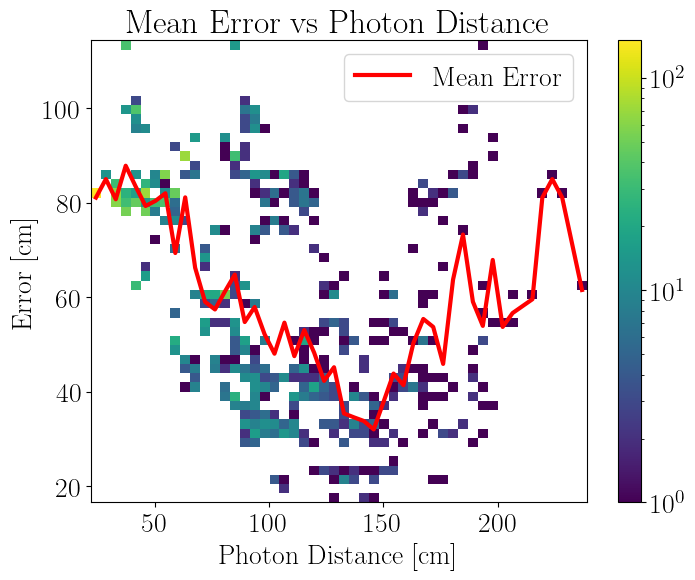

In [20]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_mean)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Mean Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

if savePlots:
    fig.savefig('../figures/trackReconstruction_meanErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

# Max Slice Reconstruction

In [21]:
showPlots = False
savePlots = False
saveAnima = False
saveDir = '../figures/voxelGrid_max/'

pos_max = np.zeros((grid.shape[0], 2))
for x in np.arange(grid.shape[0]):
    pos = grid_pos[np.where(grid_ind[:,0] == x)][:,[2,1]] # detector must be symetric
    pos_max[x] = pos[np.argmax(np.reshape(grid[x,:,:], -1))]
    plotSlice(grid, pos_max, x, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/x_{}.pdf'.format(saveDir, x))
if saveAnima:
    makeAnimation(grid, pos_max,    0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/x.gif'.format(saveDir))
X_max = np.array([np.unique(grid_pos[:,0]), pos_max[:,0], pos_max[:,1]]).T

pos_max = np.zeros((grid.shape[1], 2))
for y in np.arange(grid.shape[1]):
    pos = grid_pos[np.where(grid_ind[:,1] == y)][:,[2,0]] # detector must be symetric
    pos_max[y] = pos[np.argmax(np.reshape(grid[:,y,:], -1))]
    plotSlice(grid, pos_max, y, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/y_{}.pdf'.format(saveDir, y))
if saveAnima:
    makeAnimation(grid, pos_max,    1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/y.gif'.format(saveDir))
Y_max = np.array([pos_max[:,0], np.unique(grid_pos[:,1]), pos_max[:,1]]).T

pos_max = np.zeros((grid.shape[2],2))
for z in np.arange(grid.shape[2]):
    pos = grid_pos[np.where(grid_ind[:,2] == z)][:,[1,0]] # detector must be symetric
    pos_max[z] = pos[np.argmax(np.reshape(grid[:,:,z], -1))]
    plotSlice(grid, pos_max, z, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, show=showPlots, save=savePlots, saveName='{}/z_{}.pdf'.format(saveDir, z))
if saveAnima:
    makeAnimation(grid, pos_max,    2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, save=savePlots, saveName='{}/z.gif'.format(saveDir))
Z_max = np.array([pos_max[:,0], pos_max[:,1], np.unique(grid_pos[:,2])]).T

avg_max = np.mean(np.array([X_max,Y_max,Z_max]), axis=0)

In [22]:
A_xz = np.vstack([avg_max[:,0], np.ones(len(avg_max[:,0]))]).T
m_xz, c_xz = np.linalg.lstsq(A_xz, avg_max[:,1])[0]

A_yz = np.vstack([avg_max[:,1], np.ones(len(avg_max[:,1]))]).T
m_yz, c_yz = np.linalg.lstsq(A_yz, avg_max[:,2])[0]

def lin(z):
    x = (z - c_xz)/m_xz
    y = (z - c_yz)/m_yz
    return x, y

zz = primary_true[:,2]
xx, yy = lin(zz)

avg_max_lin = np.array([xx, yy, zz]).T

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/947378831.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_xz, c_xz = np.linalg.lstsq(A_xz, avg_max[:,1])[0]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/947378831.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_yz, c_yz = np.linalg.lstsq(A_yz, avg_max[:,2])[0]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/2299556833.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


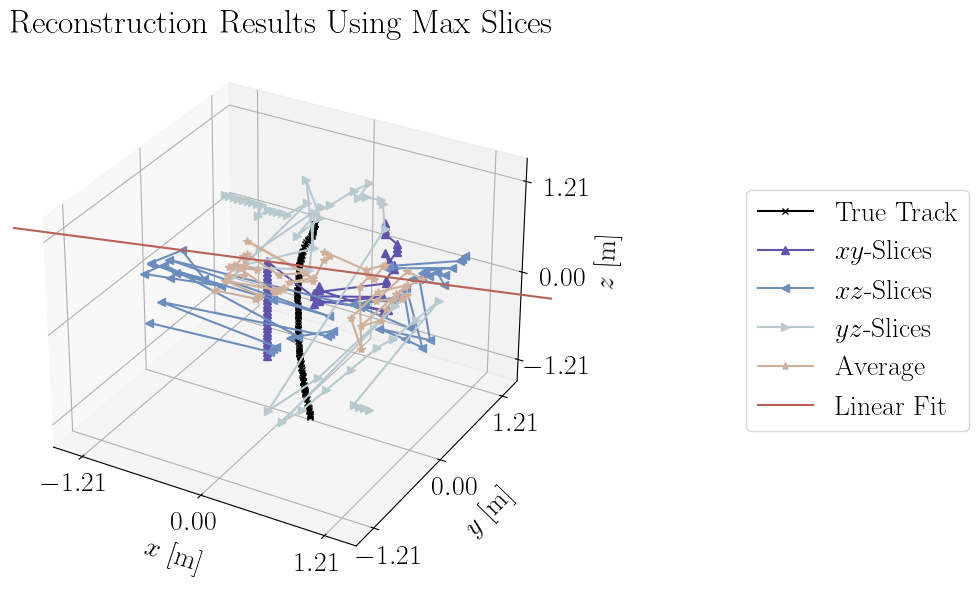

In [23]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# voxelGrid       = ax.scatter(grid_pos    [:,0]/1000, grid_pos    [:,1]/1000, grid_pos    [:,2]/1000, c=grid[grid >= 0], cmap='viridis', marker='D', alpha=0.02, s=10, norm=LogNorm())  # Use LogNorm for log scale
track_true      = ax.plot(primary_true[:,0]/1000, primary_true[:,1]/1000, primary_true[:,2]/1000, c='black'       , marker='x', markersize=5, label='True Track' , linewidth=1.5)
track_reco_Z    = ax.plot(Z_max       [:,0]/1000, Z_max       [:,1]/1000, Z_max       [:,2]/1000, c=twilight[12,:], marker='^', markersize=6, label='$xy$-Slices', linewidth=1.5)
track_reco_Y    = ax.plot(Y_max       [:,0]/1000, Y_max       [:,1]/1000, Y_max       [:,2]/1000, c=twilight[8 ,:], marker='<', markersize=6, label='$xz$-Slices', linewidth=1.5)
track_reco_X    = ax.plot(X_max       [:,0]/1000, X_max       [:,1]/1000, X_max       [:,2]/1000, c=twilight[3 ,:], marker='>', markersize=6, label='$yz$-Slices', linewidth=1.5)
track_reco      = ax.plot(avg_max     [:,0]/1000, avg_max     [:,1]/1000, avg_max     [:,2]/1000, c=twilight[35,:], marker='*', markersize=6, label='Average'    , linewidth=1.5)
track_reco_line = ax.plot(avg_max_lin [:,0]/1000, avg_max_lin [:,1]/1000, avg_max_lin [:,2]/1000, c=twilight[30,:], marker='o', markersize=0, label='Linear Fit' , linewidth=1.5)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.set_title('Reconstruction Results Using Max Slices')
ax.set_title('Reconstruction Results Using Max Slices', loc='center')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')

ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

if savePlots:
    fig.savefig('../figures/trackReconstruction_max_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/4153076661.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

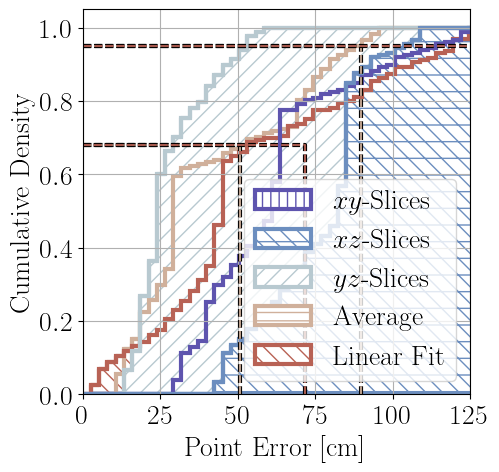

In [24]:
# %matplotlib inline

distances_X = cdist(primary_true, X_max)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_max)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_max)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_max)
distances_pts = np.min(distances_pts, axis=1)

distances_pts_lin = cdist(primary_true, avg_max_lin)
distances_pts_lin = np.min(distances_pts_lin, axis=1)

scale = 10
lw = 3
nBins = 50
alpha1 = 0.5
alpha2 = 1

PDF, _, _, bins = get_PDF(distances_pts/scale, nBins=nBins)
sigma_1_max = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max = get_CSP('2 sigma', PDF=PDF, bins=bins)
PDF, _, _, bins = get_PDF(distances_pts_lin/scale, nBins=nBins)
sigma_1_max_lin = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max_lin = get_CSP('2 sigma', PDF=PDF, bins=bins)

fig, ax_2 = plt.subplots(1, 1, figsize=(5, 5))
# max_val = np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale), np.max(distances_pts_lin/scale)])
max_val = 130
bins = np.linspace(0, max_val, nBins)

hist_X      , bins_X      , _ = ax_2.hist(distances_X      /scale, bins=bins, color=twilight[3 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-1)
hist_Y      , bins_Y      , _ = ax_2.hist(distances_Y      /scale, bins=bins, color=twilight[8 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder= 0)
hist_Z      , bins_Z      , _ = ax_2.hist(distances_Z      /scale, bins=bins, color=twilight[12,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-2)
hist_pts    , bins_pts    , _ = ax_2.hist(distances_pts    /scale, bins=bins, color=twilight[35,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-4)
hist_pts_lin, bins_pts_lin, _ = ax_2.hist(distances_pts_lin/scale, bins=bins, color=twilight[30,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-3)

ax_2.fill_between(bins_Z      [1:], hist_Z      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[12,:]), hatch=r'||' , zorder=-7, label='$xy$-Slices')
ax_2.fill_between(bins_Y      [1:], hist_Y      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[8 ,:]), hatch=r'-\\', zorder=-5, label='$xz$-Slices')
ax_2.fill_between(bins_X      [1:], hist_X      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[3 ,:]), hatch=r'//' , zorder=-6, label='$yz$-Slices')
ax_2.fill_between(bins_pts    [1:], hist_pts    , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[35,:]), hatch=r'--' , zorder=-9, label='Average'   )
ax_2.fill_between(bins_pts_lin[1:], hist_pts_lin, 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[30,:]), hatch=r'\\' , zorder=-8, label='Linear Fit')

ax_2.plot([sigma_1_max    , sigma_1_max    , 0], [0, 0.68, 0.68], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_max    , sigma_2_max    , 0], [0, 0.95, 0.95], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_1_max_lin, sigma_1_max_lin, 0], [0, 0.68, 0.68], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_max_lin, sigma_2_max_lin, 0], [0, 0.95, 0.95], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')

ax_2.set_xlabel('Point Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xticks([0, 25, 50, 75, 100, 125])
ax_2.set_xlim(xmin=0, xmax=max_val-5)
ax_2.legend(loc='lower right')
ax_2.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_maxError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

100%|██████████| 2575/2575 [00:00<00:00, 73494.15it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58510/889251872.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


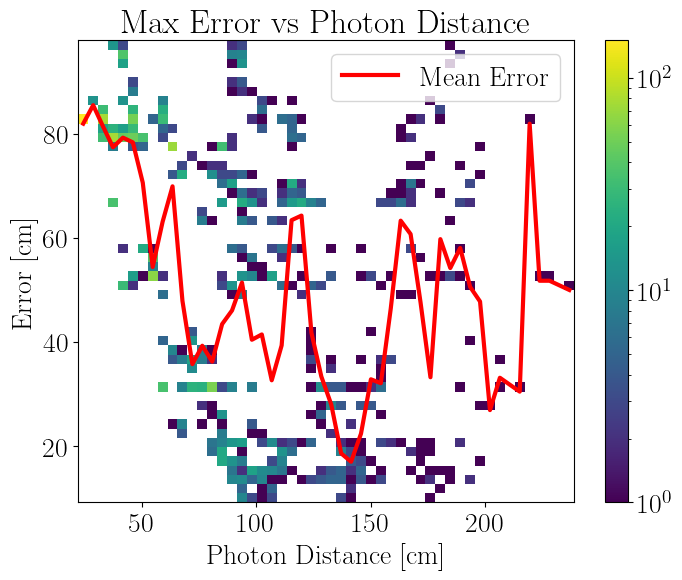

In [25]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_max)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Max Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

if savePlots:
    fig.savefig('../figures/trackReconstruction_maxErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()